In [1]:
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Notebook to modify plots for my poster

In [2]:
# Name and unit catalog for each variable
var_info = {
    "wind_speed": ("Wind speed", "m/s", (0,14)),
    "current_speed": ("Current speed", "m/s", (0,0.4)),
    "total_precipitation": ("Total precipitation", "m", (0,0.12)),
    "wave_height": ("Wave height", "m", (0,3)),
    "wave_period": ("Wave period", "s", (0,14.5)),

}
# select the stations you want to plot. /!\ You can only choose stations for one hydrophone
hydrophones = ["h1", "h2", "h3", "h4"]
variables = ["wind_speed", "current_speed", "total_precipitation", "wave_height", "wave_period"]

In [4]:
# Correlations plot
for h in hydrophones:
    fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, var in enumerate(variables):
        with open(f"../../../../data/test_correlation/data_soundscape/spectro_and_corr/{var}-{h}.pkl", "rb") as f:
            data = pickle.load(f)
        frequencies = data["frequencies"]
        correlations = data["correlations"]

        var_name, unit, scale = var_info.get(var, ("Unknown variable", "", (0,1)))

        ax = axs[i]
        ax.plot(frequencies, correlations, color="indigo", linewidth=0.5)
        ax.axhline(0, color='gray', linestyle="--", linewidth=1, alpha=0.5)

        ax.set_yticks(np.arange(-0.4, 0.81, 0.2))
        ax.set_xticks(np.arange(0, 121, 30))

        # Ax limits
        ax.set_xlim(0,120)
        ax.set_ylim(-0.4,0.75)

        ax.tick_params(axis='y', labelleft=True, labelsize=18)

        if i >= 2: # bottom row
            ax.set_xlabel("f (Hz)", fontsize=20)
            ax.tick_params(axis='x', labelbottom=True, labelsize=18)
        else:
            ax.tick_params(axis='x', labelbottom=False)

        ax.set_title(f"{var_name}", fontsize=20)

    fig.delaxes(axs[5])
    fig.suptitle(f"Spearman's correlations between PSD median amplitude and variable - {h}", fontsize=20)
    fig.text(0.06, 0.5, "Spearman's correlation coefficient", va='center', rotation='vertical', fontsize=20)

    fig.tight_layout(rect=[0.08, 0.03, 1, 0.95]) # leave space for subtitle
    fig.subplots_adjust(wspace=0.2)

    # Save figure
    output_path = f"/home/imonge/Documents/Poster"
    os.makedirs(output_path, exist_ok=True)
    fig.savefig(os.path.join(output_path, f"spearman_corr_{h}.png"))
    plt.close(fig)

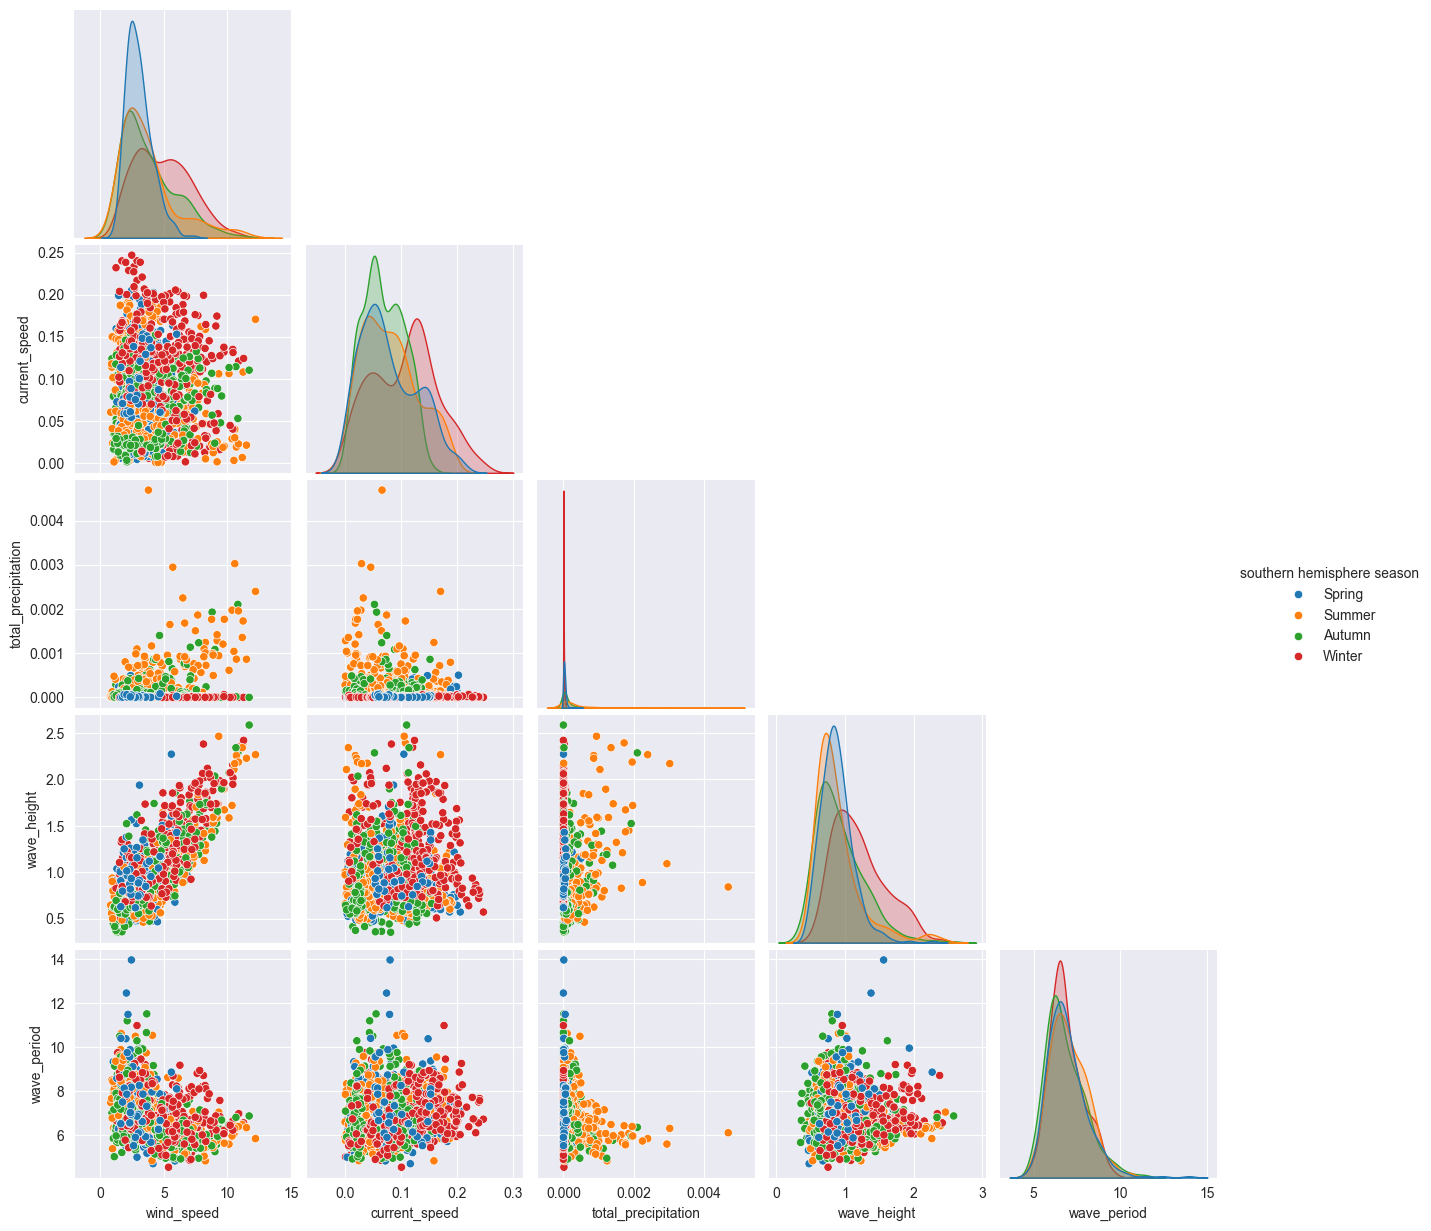

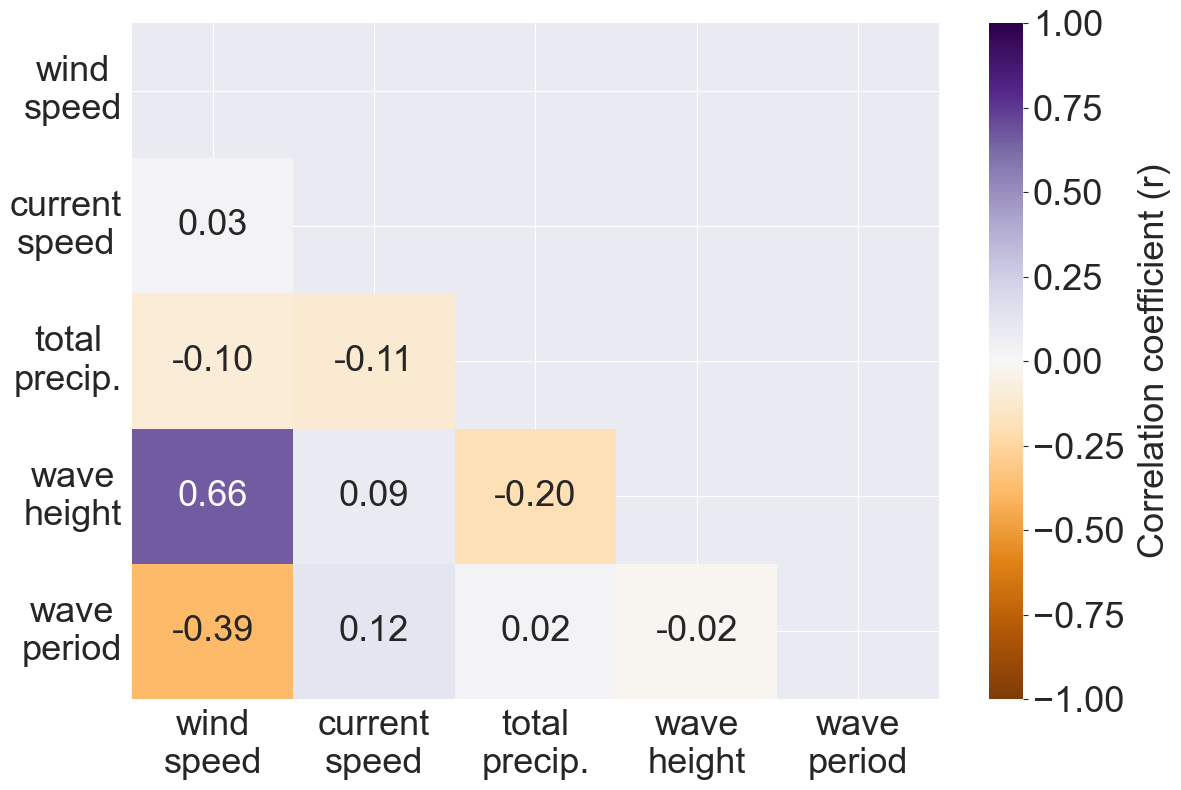

In [19]:
pca_df = pd.read_pickle("../../../../data/test_correlation/PCA/PCA.pkl")


# Ajouter un target de saison
def southern_hemisphere_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Summer"
    elif month in [3, 4, 5]:
        return "Autumn"
    elif month in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

pca_df["southern hemisphere season"] = pca_df.index.map(southern_hemisphere_season)

sns.pairplot(pca_df, hue="southern hemisphere season", corner=True)

# # Save figure
# output_pairplot = f"{output_path}/PCA_pairplot.png"
# plt.savefig(output_pairplot)
# plt.show()

# Standardisation
X = pca_df.drop(columns=["southern hemisphere season"])
y = pca_df["southern hemisphere season"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



######################################################################################
var_labels = {
    "total_precipitation": "total\nprecip.",
    "wind_speed": "wind\nspeed",
    "current_speed": "current\nspeed",
    "wave_height": "wave\nheight",
    "wave_period": "wave\nperiod",
}

# Correlations matrix (Spearman)
corr_matrix =  X.corr(method='spearman')

corr_matrix.rename(index=var_labels, columns=var_labels, inplace=True)

# Plot matrix with significant correlations
plt.figure(figsize=(12,8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Keeps half of the matrix

ax = sns.heatmap(
            corr_matrix,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap="PuOr",
            vmin=-1, vmax=1,
            cbar_kws={"label":"Correlation coefficient (r)"},
            annot_kws={"size":26}
)

# Axis and title
plt.xticks(fontsize=26)
plt.yticks(fontsize=26, rotation=0)
#
labels = [label.get_text() for label in ax.get_yticklabels()]
ax.set_yticklabels(labels, multialignment='center', rotation=0, fontsize=26)


plt.xlabel("", fontsize=26)
# plt.ylabel("", fontsize=16)

# plt.title("Correlations matrix (Spearman)", fontsize=18)

colorbar=ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=26)
colorbar.set_label("Correlation coefficient (r)", fontsize=26, labelpad=10)




plt.tight_layout()

# Save figure
output_corr_matrix = f"{output_path}/spear_corr_matrix.png"
plt.savefig(output_corr_matrix)
#plt.show()